# Introduction:
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

# Objective:

- Explore words and patterns associated with each type of cyberbullying
- Create a multiclassification model to predict cyberbullying type
- Create a binary classification model to flag potentially harmful tweets


# About the Dataset

In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

- Age;
- Ethnicity;
- Gender;
- Religion;
- Other type of cyberbullying;
- Not cyberbullying
The data has been balanced in order to contain ~8000 of each class.

Trigger Warning These tweets either describe a bullying event or are the offense themselves, therefore explore it to the point where you feel comfortable.

In [1]:
#!pip install demoji
%matplotlib inline

In [2]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import demoji

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import RandomOverSampler

#Machine learning models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec


from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
seed=42

%matplotlib inline

## Reading and visualizing the data 

In [3]:
data = pd.read_csv("cyberbullying_tweets.csv")
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


<AxesSubplot:ylabel='cyberbullying_type'>

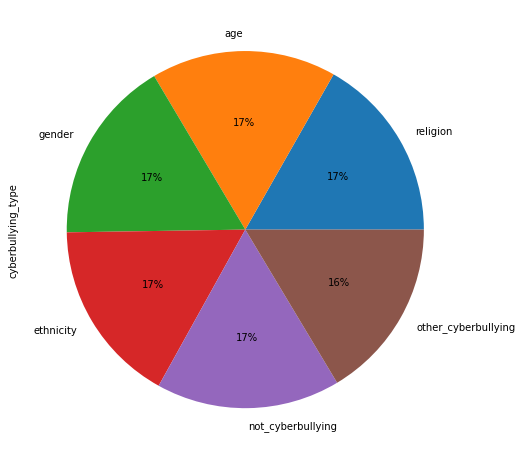

In [5]:
#View how data is distributed
print(data["cyberbullying_type"].value_counts())
plt.figure(figsize=[8, 10])
data["cyberbullying_type"].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [6]:
#Check for null values
print(data.isnull().sum())

#Check for duplicates 
print(data.duplicated().sum())

tweet_text            0
cyberbullying_type    0
dtype: int64
36


In [7]:
#Remove the duplicates 
data = data[~data.duplicated()]

We can see that all the labels are evenly distributed which is good for our model. I also checked for nulls and duplicate values in the dataset and found that there were no nulls however there were duplicates which I removed from the data

In [8]:
#Encode the categorical variable

data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


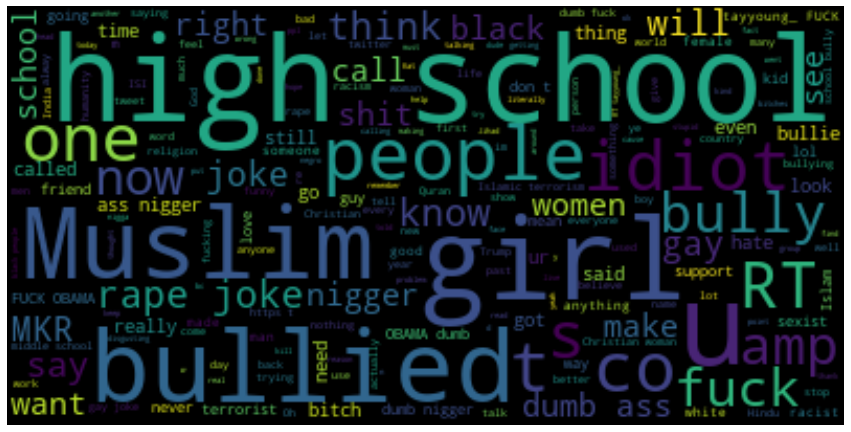

In [9]:
#Word cloud of the text in the twee
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
text = " ".join(i for i in data.tweet_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that the most common words acorss all categories are : high school, muslim, bullied, nigger, idiot, girl etc 🙏🏽

In [10]:
#Average length of tweet per class 
def average_word_length(text):
    words = text.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_word_length = round(word_length / word_count,2)
    return avg_word_length


data['tweet_length'] = data['tweet_text'].apply(lambda x: len(x.split()))
data['average_word_length'] = data['tweet_text'].apply(average_word_length)
data.head()

,tweet_text,cyberbullying_type,tweet_length,average_word_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9,5.89
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14,7.29
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9,5.78
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18,4.72
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18,4.72


(0.0, 100.0)

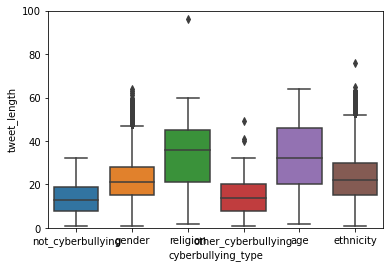

In [11]:
#Plotting the avg tweet length
import seaborn as sns
sns.boxplot(data=data, x='cyberbullying_type', y='tweet_length')
plt.ylim([0,100])


In [12]:
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

## Data Cleaning

In [13]:
ps = PorterStemmer() #Stemming is working better in our case 
lemma = WordNetLemmatizer()
import gensim
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will'])

In [14]:
def clean_text(text):
     # Remove Hashtag, Mention, https, www.something, something.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    
    #Remove contractions and multiple sequential sentences
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub("\s\s+" , " ", text)
    
    # Make all text lowercase
    text = text.lower()
    
    # Stemming word
    #tokenized = nltk.word_tokenize(text)
    text =  ' '.join([ps.stem(word) for word in text.split()])
    # " ".join([lemma.lemmatize(word) for word in text.split()])
    
    # 
    
    # Remove Punctuation
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Remove stopwords
    text = " ".join([word for word in str(text).split() if word not in stop_words])
    
    # Convert emoji to word
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)
        
    return text   

In [15]:

texts_clean = []
for text in data.tweet_text:
    texts_clean.append(clean_text(text))
data['text_clean'] = texts_clean
data.head(10)

,tweet_text,cyberbullying_type,tweet_length,average_word_length,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9,5.89,word food wa crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14,7.29,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9,5.78,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18,4.72,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18,4.72,thi isi account pretend kurdish account like i...
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,23,4.74,yes test god good bad indiffer weird whatever ...
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,10,4.50,itu sekolah ya bukan tempat bully ga jauh kaya...
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,14,3.57,karma hope bite butt nasty
8,@stockputout everything but mostly my priest,not_cyberbullying,6,6.50,everyth mostli priest
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,9,4.67,rebecca black drop school due bullying


In [16]:
#Data after cleaning
print(data.cyberbullying_type.value_counts())
data["text_clean"].duplicated().sum()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


2828

In [17]:
#Remove the duplicates 
data.drop_duplicates("text_clean", inplace=True)
print(data.cyberbullying_type.value_counts())

religion               7949
age                    7896
ethnicity              7802
not_cyberbullying      7677
gender                 7640
other_cyberbullying    5864
Name: cyberbullying_type, dtype: int64


In [18]:
data = data[data["cyberbullying_type"]!="other_cyberbullying"]
print(data.cyberbullying_type.value_counts())
data['sentiment'] = data['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,
                                                        'not_cyberbullying':4})
data.head()

religion             7949
age                  7896
ethnicity            7802
not_cyberbullying    7677
gender               7640
Name: cyberbullying_type, dtype: int64


,tweet_text,cyberbullying_type,tweet_length,average_word_length,text_clean,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9,5.89,word food wa crapilicious,4
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14,7.29,whi white,4
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9,5.78,classi whore red velvet cupcakes,4
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18,4.72,gio meh thank head concern anoth angri dude tw...,4
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18,4.72,thi isi account pretend kurdish account like i...,4


Many tweets from the class "other cyberbullying" have been erased, as can be seen and this may lead to class imbalance problems

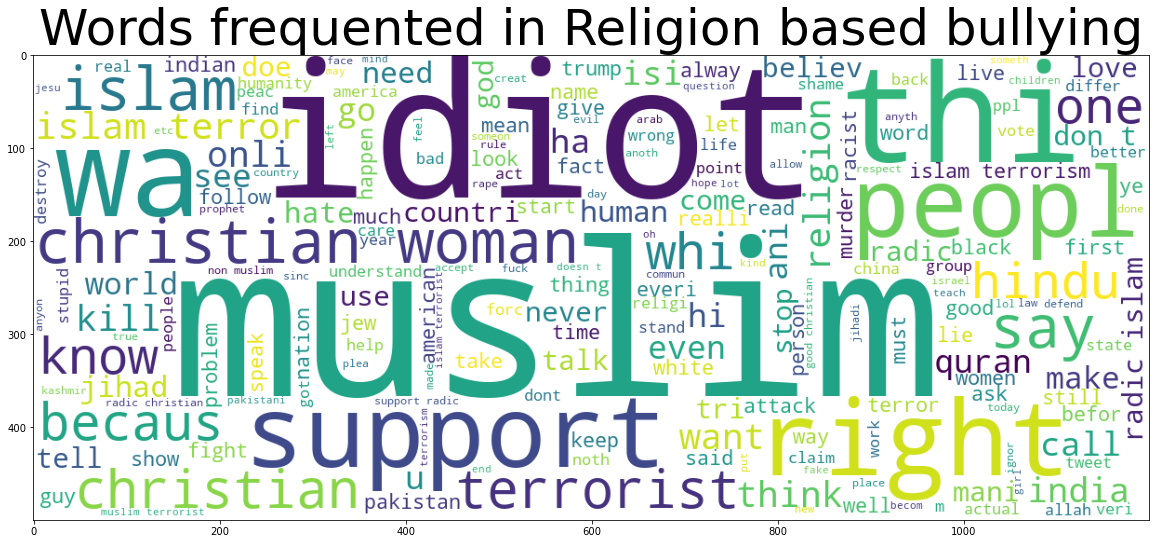

In [19]:
#Word cloud for cyber bullying type = Religion
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=1500, min_font_size=10,height=500,width=1200,
        background_color="white").generate(" ".join(data[data["sentiment"]==0].text_clean))
plt.title("Words frequented in Religion based bullying", fontsize=50)
plt.imshow(wc1)

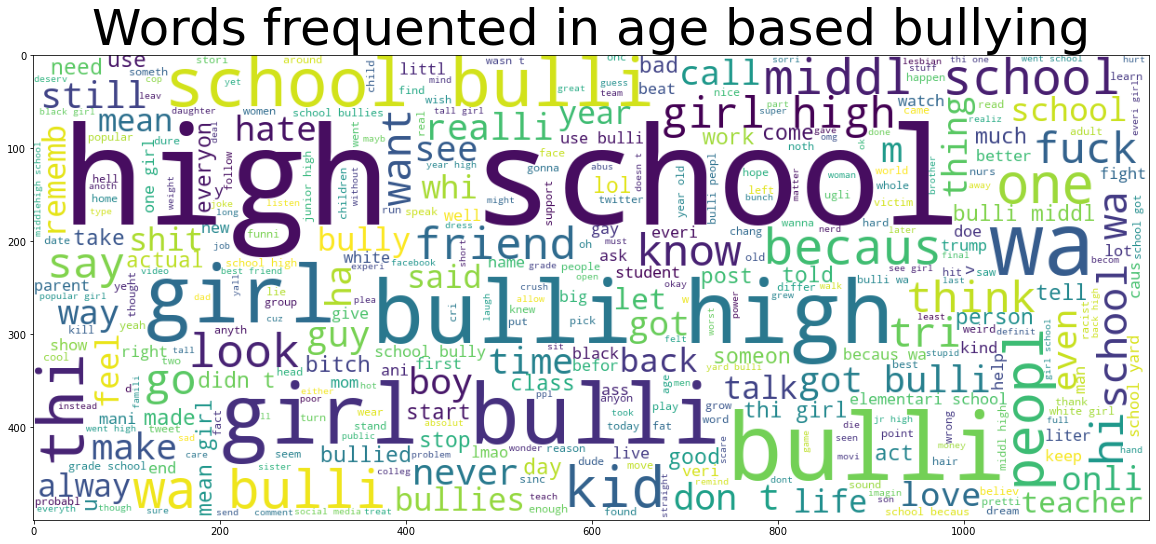

In [20]:
#Word cloud for cyber bullying type = age
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=1500, min_font_size=10,height=500,width=1200,
        background_color="white").generate(" ".join(data[data["sentiment"]==1].text_clean))
plt.title("Words frequented in age based bullying", fontsize=50)
plt.imshow(wc1)

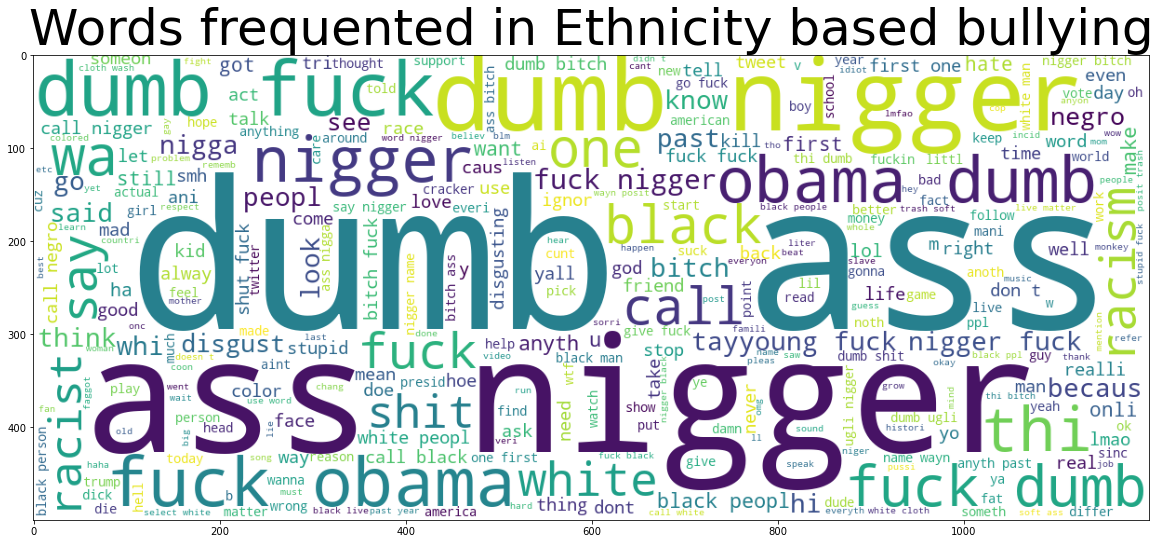

In [21]:
#Word cloud for cyber bullying type = ethnicity
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=1500, min_font_size=10,height=500,width=1200,
        background_color="white").generate(" ".join(data[data["sentiment"]==2].text_clean))
plt.title("Words frequented in Ethnicity based bullying", fontsize=50)
plt.imshow(wc1)

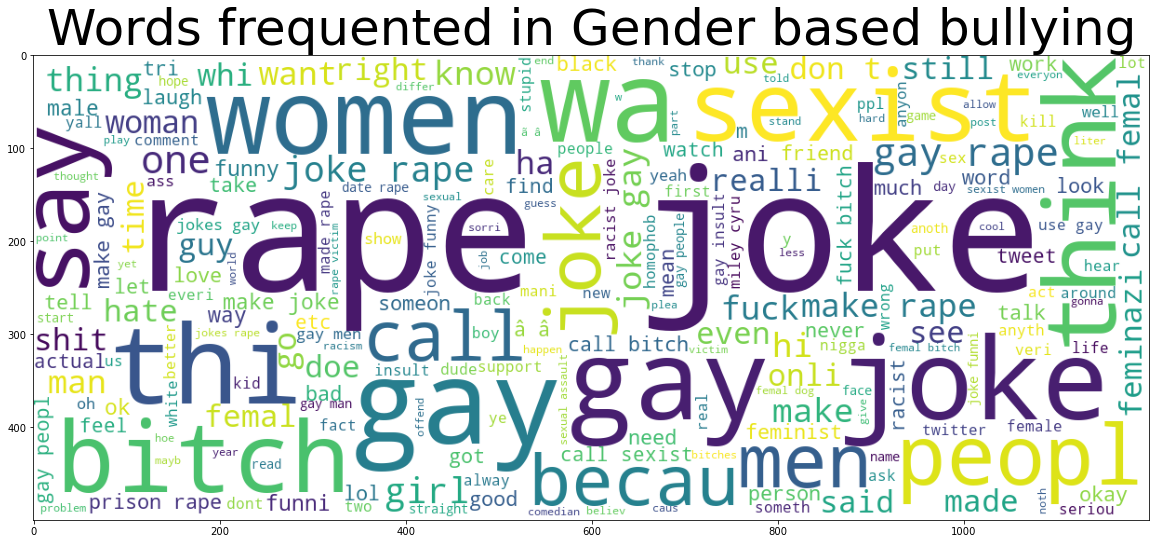

In [22]:
#Word cloud for cyber bullying type = gender
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=1500, min_font_size=10,height=500,width=1200,
        background_color="white").generate(" ".join(data[data["sentiment"]==3].text_clean))
plt.title("Words frequented in Gender based bullying", fontsize=50)
plt.imshow(wc1)

In [23]:
#Word cloud for cyber bullying type = other cyberbuylling
#plt.figure(figsize=(20,20))
#wc1 = WordCloud(max_words=1500, min_font_size=10,height=500,width=1200,
 #       background_color="white").generate(" ".join(data[data["sentiment"]==4].text_clean))
#plt.title("Words frequented in other kinds of bullying", fontsize=50)
#plt.imshow(wc1)

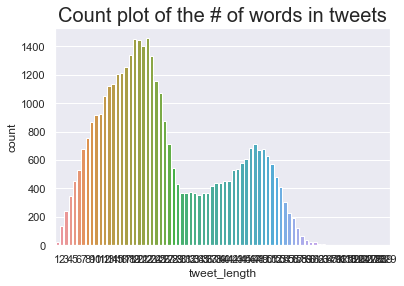

In [24]:
#Get the word length of the cleaned tweets 
import seaborn as sns
from matplotlib import rcParams
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="tweet_length", data=data)
plt.title("Count plot of the # of words in tweets", fontsize=20)
plt.rcParams['figure.figsize']=(50,50)

In [25]:
#Filter out tweets to be less than 100 words 

data = data[data['tweet_length'] < 100]

In [26]:
data.sort_values(by=["tweet_length"], ascending=False)

,tweet_text,cyberbullying_type,tweet_length,average_word_length,text_clean,sentiment
21241,And yet God was able to meet their needs using...,religion,96,4.49,yet god wa abl meet need use radical everyday ...,0
42078,FUCK TRAYVON and FUCK YOU! The lil thug nigger...,ethnicity,76,4.26,fuck trayvon fuck lil thug nigger act fool got...,2
42651,Ayy Marco my dude I remember one of our first ...,ethnicity,65,3.32,ayi marco dude rememb one first interact wa vi...,2
11082,still a female unless u a male so if u a male ...,gender,64,3.39,still femal unless male male wat bruh bt guess...,3
37624,when ur friend makes a group chat for a game w...,age,64,3.45,friend make group chat game team peopl high sc...,1
...,...,...,...,...,...,...
2555,@myk…,not_cyberbullying,1,5.00,…,4
1702,~Laura,not_cyberbullying,1,6.00,laura,4
7001,"bully,,bully",not_cyberbullying,1,12.00,bullybulli,4
3269,Steve,not_cyberbullying,1,5.00,steve,4


## Splitting into train and test data 

In [27]:
x_train, x_test, y_train, y_test = train_test_split(data['text_clean'], data['sentiment'], test_size=0.20, random_state=seed)
(x_train)

45980       fuck obama dumb ass nigger «««««dumb ass broad
33041                    thi boy bulli go school wish luck
13106    doe say don’t think rape funni anything laugh ...
17637    rest impoverished like everi muslim countri do...
5512                        stick censorship sun doe shine
                               ...                        
6464                    moment realiz follow cri happiness
11671             whyyyyyy weary_face want dumb bitch gone
46872            anyway wa also call negro white man night
874                       argh contest frustratingli annoy
16404    odeh action us prove lie crimin undoubtedli li...
Name: text_clean, Length: 31162, dtype: object

In [28]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6389],
       [   1, 6343],
       [   2, 6205],
       [   3, 6112],
       [   4, 6113]], dtype=int64)

## Machine learning Models 

### Naive Bays Classifier with BOW and TF-IDF Tranformation  (Baseline Model)

In [29]:
count_vec = CountVectorizer(ngram_range = (1,2))
x_train_cv =  count_vec.fit_transform(x_train)
x_test_cv = count_vec.transform(x_test)
x_train_cv
#Apply tf-idf tranformation to the bow
tf_transformer = TfidfTransformer(use_idf=True).fit(x_train_cv)
x_train_tf = tf_transformer.transform(x_train_cv)
x_test_tf = tf_transformer.transform(x_test_cv)
x_train_tf[0:]

<31162x300750 sparse matrix of type '<class 'numpy.float64'>'
	with 833777 stored elements in Compressed Sparse Row format>

In [30]:
#Use a Naive Bays classifier 
nb_clf = MultinomialNB()
nb_clf.fit(x_train_tf, y_train)
#Evaluate the model 
from sklearn.metrics import accuracy_score
y_pred = nb_clf.predict(x_test_tf)
print('Accuracy : %f' %(accuracy_score(y_pred, y_test)))

Accuracy : 0.812476


In [31]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, y_pred, target_names=
        ['religion','age','ethnicity','gender','other_cyberbullying']))

Classification Report for Naive Bayes:
                      precision    recall  f1-score   support

           religion       0.79      0.99      0.88      1560
                age       0.71      0.99      0.83      1552
          ethnicity       0.88      0.93      0.90      1593
             gender       0.89      0.80      0.84      1525
other_cyberbullying       0.90      0.35      0.51      1561

           accuracy                           0.81      7791
          macro avg       0.83      0.81      0.79      7791
       weighted avg       0.83      0.81      0.79      7791



## Trying Decision trees and other Ensemble methods 

In [32]:
rf = RandomForestClassifier(random_state=seed)
gb = GradientBoostingClassifier(random_state=seed)
ada = AdaBoostClassifier(random_state=seed)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=seed)
dt = DecisionTreeClassifier(random_state=seed)

classifiers = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "XGBoost": xgb,
    "Decision Tree":dt
}

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train_tf,y_train)
    y_pred = clf.predict(x_test_tf)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracys = []
for model,clf in classifiers.items():
    acc_mod = fit_model(clf,x_train_tf,y_train,x_test_tf,y_test)
    accuracys.append(acc_mod)

pd.DataFrame({"Models":classifiers.keys(),"Accuracy":accuracys}).sort_values('Accuracy',ascending=False)


C:\Users\gunja\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Models,Accuracy
0,Random Forest,0.920036
3,XGBoost,0.917854
1,Gradient Boosting,0.913362
4,Decision Tree,0.898601
2,AdaBoost,0.894109


In [33]:
model_perf = pd.DataFrame({"Models":classifiers.keys(),"Accuracy":accuracys}).sort_values('Accuracy',ascending=False)
model_perf = model_perf.append({'Models': 'Naive Bays', 
                                "Accuracy":0.812476},  ignore_index = True)
model_perf

,Models,Accuracy
0,Random Forest,0.920036
1,XGBoost,0.917854
2,Gradient Boosting,0.913362
3,Decision Tree,0.898601
4,AdaBoost,0.894109
5,Naive Bays,0.812476


In [34]:
#Use Random forest classifier 
rf = RandomForestClassifier(random_state=seed)
rf_model = rf.fit(x_train_tf,y_train)
#Evaluate the model 
y_pred = rf_model.predict(x_test_tf)
print('Accuracy : %f' %(accuracy_score(y_pred, y_test)))

Accuracy : 0.920036


### RandomSearch CV for Random Forest as it has best accuracy

In [35]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
# Use the random grid to search for best hyperparameters
#rf = RandomForestClassifier(random_state=seed)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=seed)
# Fit the random search model
#rf_random.fit(x_train_tf, y_train)

In [37]:
# Use the random grid to search for best hyperparameters
rf_random = RandomForestClassifier(bootstrap=True, max_depth=50,min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=seed)

# Fit the random search model
rf_random.fit(x_train_tf, y_train)

y_pred = rf_random.predict(x_test_tf)
print('Accuracy : %f' %(accuracy_score(y_pred, y_test)))

Accuracy : 0.895135


In [38]:
import joblib
joblib.dump(rf_model, 'RF_tweet_classifier.pkl')

['RF_tweet_classifier.pkl']

## Using LSTM

### Data Preprocessing for recurrent neural networks 

In [39]:
EMBEDDING_FILE='glove.6B.50d.txt'

In [40]:
embed_size = 50 
max_features = 20000 
maxlen = 100

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

data_upd = pd.get_dummies(data, columns=['cyberbullying_type'])
data_upd.head()

,tweet_text,tweet_length,average_word_length,text_clean,sentiment,cyberbullying_type_age,cyberbullying_type_ethnicity,cyberbullying_type_gender,cyberbullying_type_not_cyberbullying,cyberbullying_type_religion
0,"In other words #katandandre, your food was cra...",9,5.89,word food wa crapilicious,4,0,0,0,1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,14,7.29,whi white,4,0,0,0,1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,9,5.78,classi whore red velvet cupcakes,4,0,0,0,1,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",18,4.72,gio meh thank head concern anoth angri dude tw...,4,0,0,0,1,0
4,@RudhoeEnglish This is an ISIS account pretend...,18,4.72,thi isi account pretend kurdish account like i...,4,0,0,0,1,0


In [42]:
data_upd.columns

Index(['tweet_text', 'tweet_length', 'average_word_length', 'text_clean',
       'sentiment', 'cyberbullying_type_age', 'cyberbullying_type_ethnicity',
       'cyberbullying_type_gender', 'cyberbullying_type_not_cyberbullying',
       'cyberbullying_type_religion'],
      dtype='object')

In [43]:
train,test = train_test_split(data_upd, test_size=0.20, random_state=42)

list_classes = ['cyberbullying_type_age', 'cyberbullying_type_ethnicity',
       'cyberbullying_type_gender', 'cyberbullying_type_not_cyberbullying',
       'cyberbullying_type_religion']
list_sentences_train = train["text_clean"].fillna("_na_").values
y = train[list_classes].values
list_sentences_test = test["text_clean"].fillna("_na_").values

In [44]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [45]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE ,encoding="utf8"))

In [46]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

C:\Users\gunja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [47]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [49]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation="softmax")(x)
lstmmodel = tf.keras.Model(inputs=inp, outputs=x)
lstmmodel.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [50]:
lstmmodel.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
877/877 [==============================] - 133s 152ms/step - loss: 0.1486 - accuracy: 0.8502 - val_loss: 0.0944 - val_accuracy: 0.9057
Epoch 2/2
877/877 [==============================] - 127s 144ms/step - loss: 0.0821 - accuracy: 0.9209 - val_loss: 0.0831 - val_accuracy: 0.9211


In [51]:
y_test = lstmmodel.predict([X_te], batch_size=1024, verbose=1)

8/8 [==============================] - 2s 218ms/step


In [52]:
lstmmodel.evaluate([X_te], y = test[list_classes].values)

244/244 [==============================] - 5s 18ms/step - loss: 0.0865 - accuracy: 0.9162


[0.08653144538402557, 0.9161853194236755]

In [53]:
model_perf = pd.DataFrame({"Models":classifiers.keys(),"Accuracy":accuracys}).sort_values('Accuracy',ascending=False)
model_perf = model_perf.append({'Models': 'LSTM', 
                                "Accuracy":0.913618266582489},  ignore_index = True)
model_perf.sort_values(by = 'Accuracy', ascending = False)

,Models,Accuracy
0,Random Forest,0.920036
1,XGBoost,0.917854
5,LSTM,0.913618
2,Gradient Boosting,0.913362
3,Decision Tree,0.898601
4,AdaBoost,0.894109


## Using Twitter to make predictions on covid data

In [54]:
import os
import tweepy as tw

In [82]:
#consumer_key= 'CANNOT SHARE'
#consumer_secret= 'jCANNOT SHARE'
#access_token= 'CANNOT SHARE'
#access_token_secret= 'wANNOT SHARE'

In [56]:
#auth = tw.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tw.API(auth, wait_on_rate_limit=True)

In [57]:
#search_words = "pandemic"
#date_since = "2021-05-01"
#new_search = search_words + " -filter:retweets"
#new_search

'pandemic -filter:retweets'

In [58]:
#tweets = tw.Cursor(api.search_tweets,
             # q=search_words,
             # lang="en",
             # since=date_since).items(10)
#tweets

In [59]:
#covid_19_tweets = pd.DataFrame([tweet.text for tweet in tweets])

Unexpected parameter: since


In [60]:
#covid_19_tweets.to_csv('covid19_tweets2.csv')

In [85]:
#Read the data
test_data_covid = pd.read_csv('covid19_tweets.csv')
test_data_covid
texts_clean = []
for text in test_data_covid.text:
    texts_clean.append(clean_text(text))
test_data_covid['text_cleaned'] = texts_clean
test_data_covid.head(10)

,text,text_cleaned
0,If I smelled the scent of hand sanitizers toda...,smell scent hand sanit today someon past would...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey would made sens player pay respect a…
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,trump never onc claim wa hoax claim thi effort...
3,@brookbanktv The one gift #COVID19 has give me...,one gift ha give appreci simpl thing alway aro...
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 juli media bulletin novel …
5,#coronavirus #covid19 deaths continue to rise....,death continu rise almost bad ever politician ...
6,How #COVID19 Will Change Work in General (and ...,chang work gener recruiting specifically via …
7,You now have to wear face coverings when out s...,wear face cover shop thi includ visit local co...
8,Praying for good health and recovery of @Chouh...,pray good health recoveri
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,pope god prophet sadhu sundar selvaraj watch …


# Using Random Forest to predict

In [86]:
#Using RFForest 
x_covid_cv = count_vec.transform(test_data_covid['text'])
#Apply tf-idf tranformation to the bow
x_covid_tf = tf_transformer.transform(x_train_cv)
x_train_tf[0:]

<31162x300750 sparse matrix of type '<class 'numpy.float64'>'
	with 833777 stored elements in Compressed Sparse Row format>

In [87]:
y_pred = rf_model.predict(x_covid_cv)

In [89]:
covid_rf = pd.concat([test_data_covid['text'], pd.Series(y_pred)], axis=1)
covid_rf.columns = ['tweet','cyberbullying_pred']

In [90]:
#covid_rf
#covid_rf.cyberbullying_pred.replace({0: 10, 1: 100})

# Using LSTM to predict

In [91]:
#Prediction using LSTM model

In [92]:
test_covid = test_data_covid['text_cleaned'].fillna('')
list_sentences_test = test_data_covid["text_cleaned"].fillna("_na_").values

In [93]:
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
C_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [94]:
pred = lstmmodel.predict([C_te], batch_size=1024, verbose=1)

175/175 [==============================] - 36s 206ms/step


In [95]:
covid_predicted = pd.DataFrame(pred, columns = ['age', 'ethnicity',
       'gender', 'not_cyberbullying',
       'religion'])
covid_predicted

,age,ethnicity,gender,not_cyberbullying,religion
0,0.008332,0.020537,0.119349,0.838362,0.013420
1,0.005655,0.004065,0.246886,0.722311,0.021082
2,0.003429,0.006961,0.104190,0.777896,0.107525
3,0.004317,0.006822,0.170017,0.802350,0.016493
4,0.003005,0.007506,0.253989,0.693409,0.042091
...,...,...,...,...,...
179103,0.005003,0.002502,0.086423,0.894769,0.011302
179104,0.004055,0.004276,0.228925,0.741639,0.021105
179105,0.007042,0.022467,0.070946,0.863745,0.035800
179106,0.006641,0.003565,0.115732,0.863614,0.010448


In [96]:
covid_predicted['cyberbullying_pred'] = covid_predicted.idxmax(axis=1)

In [97]:
covid_final = pd.concat([test_data_covid['text'], covid_predicted['cyberbullying_pred']], axis=1)
covid_final.columns = ['tweet','cyberbullying_pred']

In [98]:
covid_final

,tweet,cyberbullying_pred
0,If I smelled the scent of hand sanitizers toda...,not_cyberbullying
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,not_cyberbullying
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,not_cyberbullying
3,@brookbanktv The one gift #COVID19 has give me...,not_cyberbullying
4,25 July : Media Bulletin on Novel #CoronaVirus...,not_cyberbullying
...,...,...
179103,Thanks @IamOhmai for nominating me for the @WH...,not_cyberbullying
179104,2020! The year of insanity! Lol! #COVID19 http...,not_cyberbullying
179105,@CTVNews A powerful painting by Juan Lucena. I...,not_cyberbullying
179106,"More than 1,200 students test positive for #CO...",not_cyberbullying


## Analysing Predicitions 

In [99]:
covid_final.cyberbullying_pred.value_counts()

not_cyberbullying    172645
gender                 3774
religion               1234
ethnicity               909
age                     546
Name: cyberbullying_pred, dtype: int64

In [124]:
searchwords = ['asian','china']

covid_final['tweet'] = covid_final['tweet'].str.lower()

covid_buylling = covid_final[covid_final['cyberbullying_pred'] != "not_cyberbullying"]
print(covid_buylling[covid_buylling['tweet'].str.startswith(tuple(searchwords))][:1]['tweet'])

9942    asian australians threatened and spat on in ra...
Name: tweet, dtype: object


## Making the working application

In [132]:
#CReate thw running application 
from flask import Flask,render_template,url_for,request
import pandas as pd 
import pickle
seed=42

%matplotlib inline
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('home.html')

@app.route('/predict',methods=['POST'])
def predict():

    if request.method == 'POST':
        message = request.form['message']
        data = [message]
        
        #Using RFForest 
        vect = count_vec.transform(data)
        x_covid_tf = tf_transformer.transform(vect)
        my_prediction = rf_model.predict(vect)
        
    return render_template('result.html',prediction = my_prediction)

In [ ]:
app.run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Mar/2022 00:37:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:37:14] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:37:35] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:37:35] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:39:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:39:14] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:39:44] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:39:44] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:39:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:39:55] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:40:17] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [14/Mar/2022 00:40:17] "GET /static/css/styles.css HTTP/1.1" 404 -
127.0.0.1 - - [14/Mar/2022 00:40:25] "GET / HTTP/1.1" 200 -
127.0.0.1 